# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

From a data science perspective, we can view this problem as identifying most important features in the dataset that drive the used car prices. Given that we have car price in the dataset and it is a continuous numerical value, this is a supervised machine learning problem where we use regression models to predict the target (car price), using other columns (the features) in the dataset. One of the simple yet effective and powerful regression technique is linear regression. With sufficient and high quality data, proper hyperparameter tuning and cross-validation, we can train linear regression models that can predict used car prices with high accuracy and thus identify the key features that determine used car prices.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

The steps we should take to get familiar with the data are:
1. Have a high level overview: number of observations, what are the features and their types (number or category), do we understand the feature's meaning?
2. Check for invalid data within each feature (missing data, misspells, negative values for positive-only feature, etc.)
3. Look at data distributions: is the data highly skewed towards certain values or evenly distributed? Any outlier?
4. Chek for feature correlation: high correlation between features may indicate redundancy

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_transformer, TransformedTargetRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

import plotly.express as px
import seaborn as sns

In [2]:
df = pd.read_csv('data/vehicles.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [4]:
df.describe()

,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


In [5]:
df.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [6]:
# check unique values 
for col in df.columns:
    if not col in ['id', 'price', 'odometer', 'year']:
        print(col, df[col].unique())

region ['prescott' 'fayetteville' 'florida keys' 'worcester / central MA'
 'greensboro' 'hudson valley' 'medford-ashland' 'erie' 'el paso'
 'bellingham' 'skagit / island / SJI' 'la crosse' 'auburn' 'birmingham'
 'dothan' 'florence / muscle shoals' 'gadsden-anniston'
 'huntsville / decatur' 'mobile' 'montgomery' 'tuscaloosa'
 'anchorage / mat-su' 'fairbanks' 'kenai peninsula' 'southeast alaska'
 'flagstaff / sedona' 'mohave county' 'phoenix' 'show low' 'sierra vista'
 'tucson' 'yuma' 'fort smith' 'jonesboro' 'little rock' 'texarkana'
 'bakersfield' 'chico' 'fresno / madera' 'gold country' 'hanford-corcoran'
 'humboldt county' 'imperial county' 'inland empire' 'los angeles'
 'mendocino county' 'merced' 'modesto' 'monterey bay' 'orange county'
 'palm springs' 'redding' 'reno / tahoe' 'sacramento' 'san diego'
 'san luis obispo' 'santa barbara' 'santa maria' 'SF bay area'
 'siskiyou county' 'stockton' 'susanville' 'ventura county'
 'visalia-tulare' 'yuba-sutter' 'boulder' 'colorado springs'

In [7]:
# create new column manufacturer_model
df = df.drop_duplicates()
df['manufacturer'] = df['manufacturer'].fillna('missing')
df['model'] = df['model'].fillna('missing')
df['manufacturer_model'] = df['manufacturer'] + '___' + df['model']

# add average price for manufacturer_model
df_mm_avg_price = df.groupby('manufacturer_model')[['price']].agg('mean').reset_index().rename(columns={'price': 'avg_price'})
df = pd.merge(left=df, right=df_mm_avg_price, on='manufacturer_model', how='left')

In [8]:
# create age column
df['age'] = datetime.now().year - df['year']
# drop these columns
df.drop(['id', 'year', 'region', 'VIN', 'state', 'manufacturer', 'model', 'manufacturer_model', 'size', 'paint_color'], axis=1, inplace=True)

Text(0.5, 1.0, 'Price boxplot')

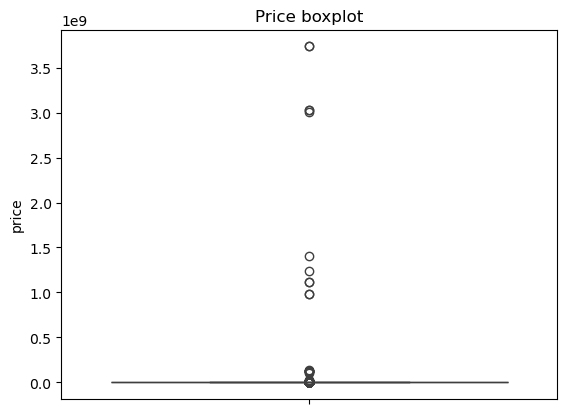

In [9]:
sns.boxplot(df['price'])
plt.title('Price boxplot')

In [10]:
# remove outliers
df = df[(df['price'] > 0) & (df['price'] < 550_000)]

Text(0.5, 1.0, 'Odometer boxplot')

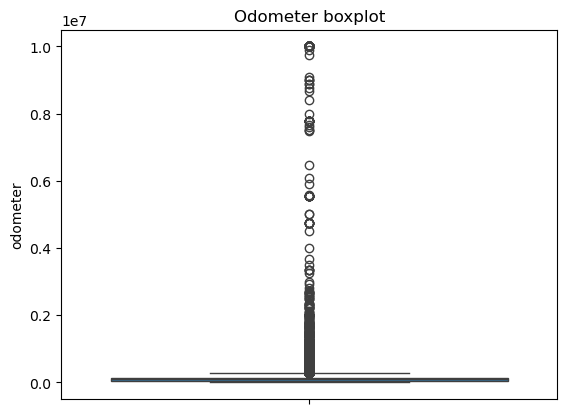

In [11]:
sns.boxplot(df['odometer'])
plt.title('Odometer boxplot')

In [12]:
# remove odometer outlier and artificial odometer
df = df[(df['odometer'] < 999_999) & (df['odometer'] != 123_456) & (df['odometer'] != 111_111) & (df['odometer'] != 99_999)]

Text(0.5, 1.0, 'Price vs odometer vs age pairplot')

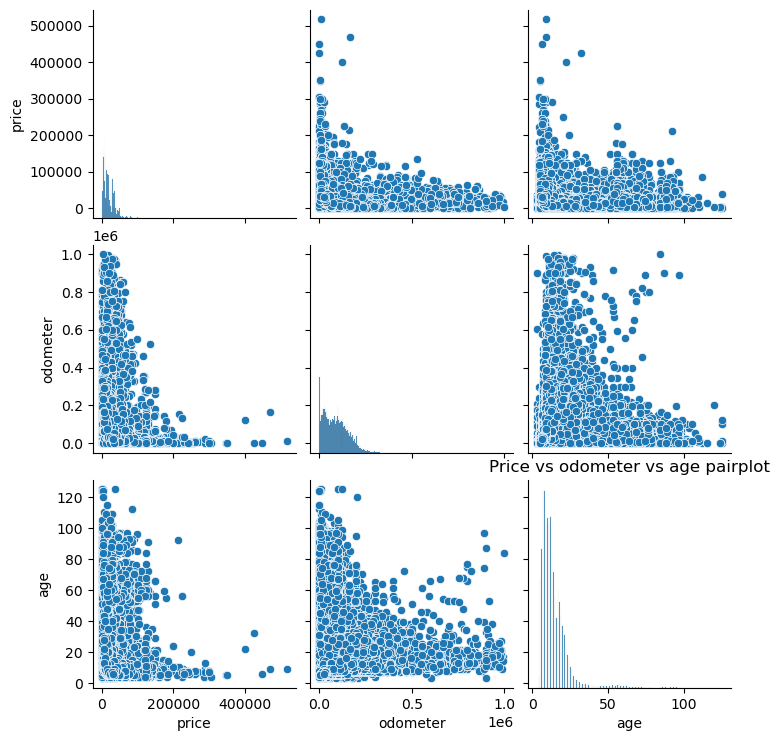

In [13]:
sns.pairplot(df[['price', 'odometer', 'age']])
plt.title('Price vs odometer vs age pairplot')

Text(0.5, 1.0, 'Title Status vs Price boxplot')

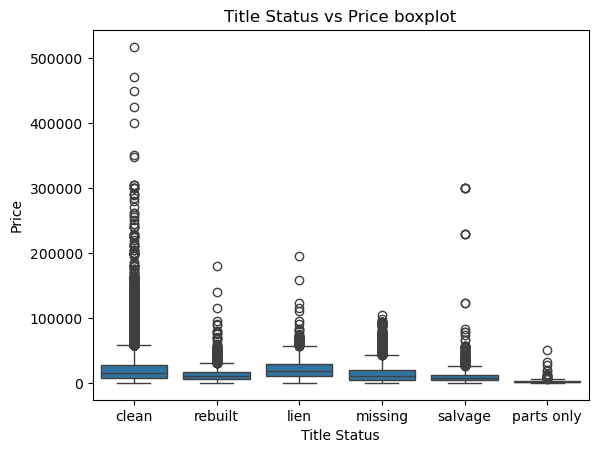

In [14]:
df['title_status'] = df['title_status'].fillna('missing')
sns.boxplot(x=df['title_status'], y=df['price'])
plt.xlabel('Title Status')
plt.ylabel('Price')
plt.title('Title Status vs Price boxplot')

Text(0.5, 1.0, 'Cylinders vs Price boxplot')

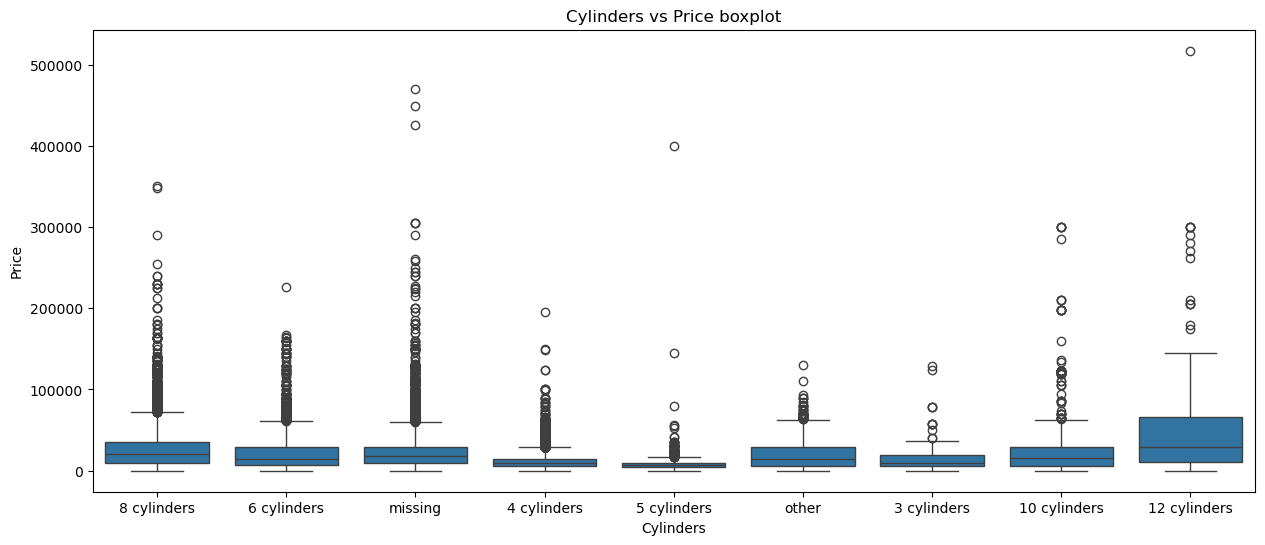

In [15]:
df['cylinders'] = df['cylinders'].fillna('missing')
plt.figure(figsize=(15, 6))
sns.boxplot(x=df['cylinders'], y=df['price'])
plt.xlabel('Cylinders')
plt.ylabel('Price')
plt.title('Cylinders vs Price boxplot')

Text(0.5, 1.0, 'Fuel vs Price boxplot')

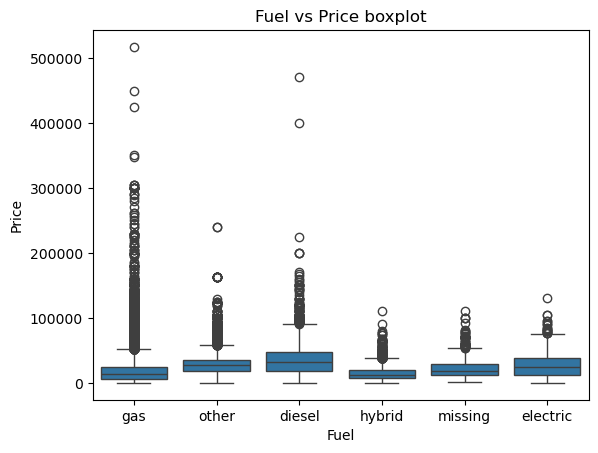

In [16]:
df['fuel'] = df['fuel'].fillna('missing')
sns.boxplot(x=df['fuel'], y=df['price'])
plt.xlabel('Fuel')
plt.ylabel('Price')
plt.title('Fuel vs Price boxplot')

Text(0.5, 1.0, 'Transmission vs Price boxplot')

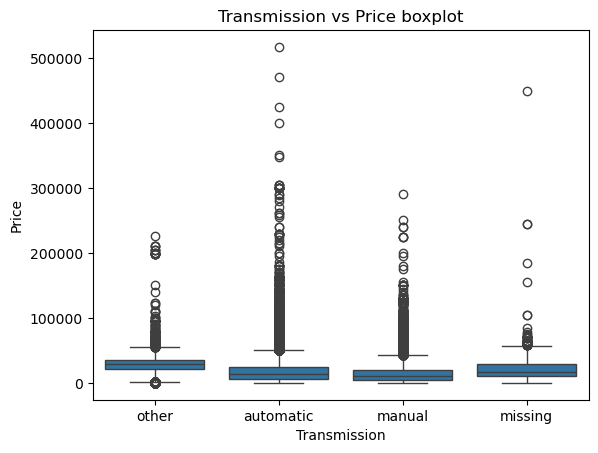

In [17]:
df['transmission'] = df['transmission'].fillna('missing')
sns.boxplot(x=df['transmission'], y=df['price'])
plt.xlabel('Transmission')
plt.ylabel('Price')
plt.title('Transmission vs Price boxplot')

In [18]:
# there is an order in the condition, Nan replaced by mode
# since there is a lot of missing value in the condition, let's add another indicator to tell the model that the condition value is missing before imputation
df['condition_missing'] = 0
df.loc[df['condition'].isnull(), 'condition_missing'] = 1
condition_mapping = {'good':3, 'excellent':4, 'fair':2, 'like new':5, 'new':6, 'salvage':1}
df['condition'] = df['condition'].map(condition_mapping)
df['condition'] = df['condition'].fillna(df['condition'].mode()[0])
df

,price,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,avg_price,age,condition_missing
27,33590,3.0,8 cylinders,gas,57923.0,clean,other,NaN,pickup,35224.934498,11.0,0
28,22590,3.0,8 cylinders,gas,71229.0,clean,other,NaN,pickup,20632.919261,15.0,0
29,39590,3.0,8 cylinders,gas,19160.0,clean,other,NaN,pickup,34064.275930,5.0,0
30,30990,3.0,8 cylinders,gas,41124.0,clean,other,NaN,pickup,34749.481707,8.0,0
31,15000,4.0,6 cylinders,gas,128000.0,clean,automatic,rwd,truck,18410.348361,12.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
426875,23590,3.0,6 cylinders,gas,32226.0,clean,other,fwd,sedan,23979.681818,6.0,0
426876,30590,3.0,missing,gas,12029.0,clean,other,fwd,sedan,29800.909091,5.0,0
426877,34990,3.0,missing,diesel,4174.0,clean,other,NaN,hatchback,34566.344086,5.0,0
426878,28990,3.0,6 cylinders,gas,30112.0,clean,other,fwd,sedan,24225.745856,7.0,0


Text(0.5, 1.0, 'Type vs Price boxplot')

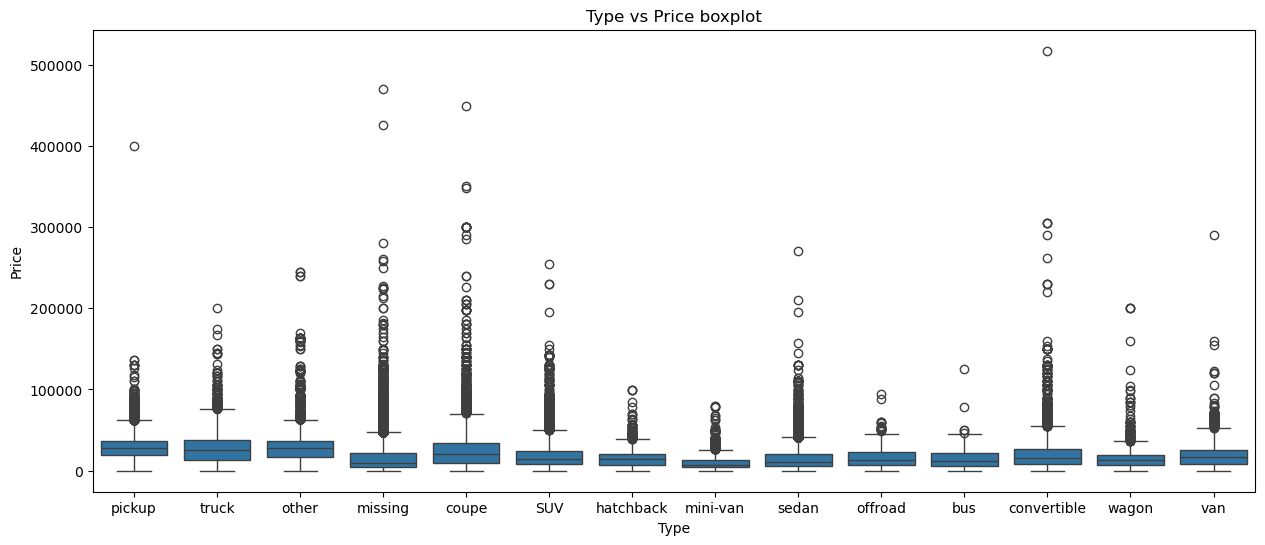

In [19]:
df['type'] = df['type'].fillna('missing')
plt.figure(figsize=(15, 6))
sns.boxplot(x=df['type'], y=df['price'])
plt.xlabel('Type')
plt.ylabel('Price')
plt.title('Type vs Price boxplot')

Text(0.5, 1.0, 'Drive vs Price boxplot')

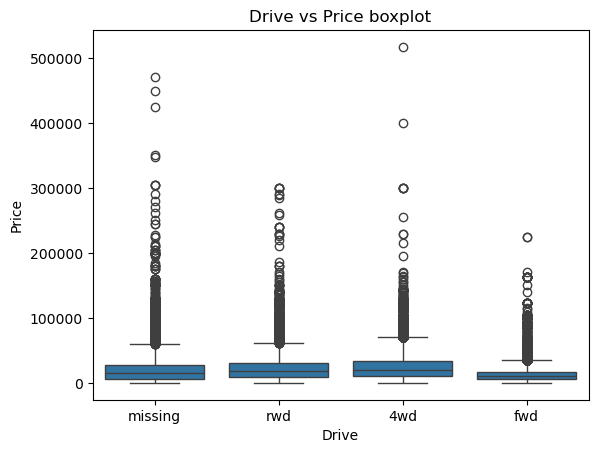

In [20]:
df['drive'] = df['drive'].fillna('missing')
sns.boxplot(x=df['drive'], y=df['price'])
plt.xlabel('Drive')
plt.ylabel('Price')
plt.title('Drive vs Price boxplot')

In [21]:
df.dropna(subset=['age', 'fuel', 'odometer'], inplace=True)
df = df.drop_duplicates()
df

,price,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,avg_price,age,condition_missing
27,33590,3.0,8 cylinders,gas,57923.0,clean,other,missing,pickup,35224.934498,11.0,0
28,22590,3.0,8 cylinders,gas,71229.0,clean,other,missing,pickup,20632.919261,15.0,0
29,39590,3.0,8 cylinders,gas,19160.0,clean,other,missing,pickup,34064.275930,5.0,0
30,30990,3.0,8 cylinders,gas,41124.0,clean,other,missing,pickup,34749.481707,8.0,0
31,15000,4.0,6 cylinders,gas,128000.0,clean,automatic,rwd,truck,18410.348361,12.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
426833,6800,3.0,8 cylinders,gas,69550.0,clean,automatic,rwd,convertible,11904.200000,28.0,0
426838,21900,3.0,6 cylinders,gas,11065.0,clean,manual,rwd,other,21900.000000,105.0,0
426839,54999,3.0,missing,gas,119000.0,clean,automatic,missing,missing,48584.414634,8.0,1
426846,41999,3.0,missing,gas,126000.0,clean,automatic,missing,missing,30860.035714,10.0,1


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 226973 entries, 27 to 426873
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              226973 non-null  int64  
 1   condition          226973 non-null  float64
 2   cylinders          226973 non-null  object 
 3   fuel               226973 non-null  object 
 4   odometer           226973 non-null  float64
 5   title_status       226973 non-null  object 
 6   transmission       226973 non-null  object 
 7   drive              226973 non-null  object 
 8   type               226973 non-null  object 
 9   avg_price          226973 non-null  float64
 10  age                226973 non-null  float64
 11  condition_missing  226973 non-null  int64  
dtypes: float64(4), int64(2), object(6)
memory usage: 22.5+ MB


### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

### Model 1. Use Ridge regression with grid search and cross-validation

In [23]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,1:], df['price'], test_size = 0.2, random_state = 42)

In [24]:
# create two Ridge models: one using raw price as target, the second using log price
process_pipe = Pipeline([
    ('poly_features', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler())
])

transformer = make_column_transformer(
    (process_pipe, ['condition', 'odometer', 'age', 'avg_price']),
    (OneHotEncoder(sparse_output=False, handle_unknown='ignore'), X_train.select_dtypes(include='object').columns),
    remainder='passthrough'
)

ridge_raw = Pipeline([
    ('transformer', transformer),
    ('ridge', Ridge())
])

ridge_raw_2 = Pipeline([
    ('transformer', transformer),
    ('ridge', Ridge())
])

ridge_log = TransformedTargetRegressor(
    regressor = ridge_raw_2,
    func=np.log,
    inverse_func=np.exp
)

ridge_raw_param_dict = {'ridge__alpha': np.logspace(-4, 3, 20)}
ridge_log_param_dict = {'regressor__ridge__alpha': np.logspace(-4, 3, 20)}

grid_raw = GridSearchCV(estimator=ridge_raw, param_grid = ridge_raw_param_dict, scoring = 'neg_mean_squared_error', cv = 5)
grid_log = GridSearchCV(estimator=ridge_log, param_grid = ridge_log_param_dict, scoring = 'neg_mean_squared_log_error', cv = 5)

In [25]:
grid_raw.fit(X_train,y_train)
grid_log.fit(X_train,y_train)

,estimator,"TransformedTa...', Ridge())]))"
,param_grid,{'regressor__ridge__alpha': array([1.0000...00000000e+03])}
,scoring,'neg_mean_squared_log_error'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('pipeline', ...), ('onehotencoder', ...)]"


In [26]:
# extract the raw model coefficients
best_ridge_raw_grid = grid_raw.best_estimator_
best_ridge_raw_model = best_ridge_raw_grid.named_steps['ridge']
fitted_transformer = best_ridge_raw_grid.named_steps['transformer']
ridge_raw_df = pd.DataFrame({'feature': fitted_transformer.get_feature_names_out(), 'coef': best_ridge_raw_model.coef_}).sort_values(by='coef', ascending=False)

In [27]:
ridge_raw_df

,feature,coef
15,onehotencoder__cylinders_12 cylinders,29892.479572
11,pipeline__age^2,10184.623084
23,onehotencoder__fuel_diesel,10154.846349
30,onehotencoder__title_status_lien,4702.837879
45,onehotencoder__type_convertible,3614.232350
52,onehotencoder__type_pickup,3187.263097
29,onehotencoder__title_status_clean,3112.947457
6,pipeline__condition age,2987.129695
8,pipeline__odometer^2,2977.686461
39,onehotencoder__drive_4wd,2875.966294


In [28]:
# extract the log model coefficients
best_ridge_log_grid = grid_log.best_estimator_
best_ridge_log_model = best_ridge_log_grid.regressor_.named_steps['ridge']
fitted_transformer = best_ridge_log_grid.regressor_.named_steps['transformer']
ridge_log_df = pd.DataFrame({'feature': fitted_transformer.get_feature_names_out(), 'coef': best_ridge_log_model.coef_}).sort_values(by='coef', ascending=False)

In [29]:
ridge_log_df

,feature,coef
0,pipeline__condition,0.680127
15,onehotencoder__cylinders_12 cylinders,0.655184
11,pipeline__age^2,0.645804
30,onehotencoder__title_status_lien,0.486190
23,onehotencoder__fuel_diesel,0.471706
29,onehotencoder__title_status_clean,0.316528
50,onehotencoder__type_offroad,0.294715
20,onehotencoder__cylinders_8 cylinders,0.246859
27,onehotencoder__fuel_missing,0.238105
6,pipeline__condition age,0.209839


### Model 2. Use Lasso regression

In [30]:
# similarly, we train two models (raw and log target price)
lasso_raw = Pipeline([
    ('transformer', transformer),
    ('lasso', LassoCV(alphas=np.logspace(-4, 1, 50), cv=5, random_state = 42))
])

lasso_raw_2 = Pipeline([
    ('transformer', transformer),
    ('lasso', LassoCV(alphas=np.logspace(-4, 1, 50), cv=5, random_state = 42))
])

lasso_log = TransformedTargetRegressor(
    regressor = lasso_raw_2,
    func=np.log,
    inverse_func=np.exp
)
lasso_raw.fit(X_train, y_train)
lasso_log.fit(X_train, y_train)

C:\Users\hidden01\anaconda3\envs\UCB\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.902e+11, tolerance: 3.894e+09
  model = cd_fast.enet_coordinate_descent(
C:\Users\hidden01\anaconda3\envs\UCB\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.496e+01, tolerance: 2.637e+01
  model = cd_fast.enet_coordinate_descent(


,regressor,Pipeline(step...m_state=42))])
,transformer,None
,func,<ufunc 'log'>
,inverse_func,<ufunc 'exp'>
,check_inverse,True
,transformers,"[('pipeline', ...), ('onehotencoder', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False


In [31]:
# extract the raw model coefficients
best_lasso_raw = lasso_raw.named_steps['lasso']
lasso_raw_coef = best_lasso_raw.coef_
lasso_raw_df = pd.DataFrame({'feature': lasso_raw.named_steps['transformer'].get_feature_names_out(), 'coef': lasso_raw_coef}).sort_values(by='coef', ascending=False)

In [32]:
lasso_raw_df

,feature,coef
15,onehotencoder__cylinders_12 cylinders,32686.430005
23,onehotencoder__fuel_diesel,12026.506129
11,pipeline__age^2,10181.184309
30,onehotencoder__title_status_lien,5340.859493
14,onehotencoder__cylinders_10 cylinders,5040.812091
45,onehotencoder__type_convertible,4036.688651
29,onehotencoder__title_status_clean,3772.062805
39,onehotencoder__drive_4wd,3668.994032
52,onehotencoder__type_pickup,3615.001025
46,onehotencoder__type_coupe,3152.439530


In [33]:
# extract the log model coefficients
best_lasso_log = lasso_log.regressor_.named_steps['lasso']
lasso_log_coef = best_lasso_log.coef_
lasso_log_df = pd.DataFrame({'feature': lasso_log.regressor_.named_steps['transformer'].get_feature_names_out(), 'coef': lasso_log_coef}).sort_values(by='coef', ascending=False)

In [34]:
lasso_log_df

,feature,coef
0,pipeline__condition,0.678668
11,pipeline__age^2,0.645490
23,onehotencoder__fuel_diesel,0.627234
15,onehotencoder__cylinders_12 cylinders,0.597284
27,onehotencoder__fuel_missing,0.379127
30,onehotencoder__title_status_lien,0.322329
20,onehotencoder__cylinders_8 cylinders,0.264979
50,onehotencoder__type_offroad,0.234311
6,pipeline__condition age,0.209941
39,onehotencoder__drive_4wd,0.182234


### Model 3. Use Sequential Feature Selector with Linear Regression

In [35]:
# use raw target price
seq_raw = Pipeline([
    ('transformer', transformer),
    ('seq_selector', SequentialFeatureSelector(LinearRegression(), n_features_to_select=10)),
    ('linreg', LinearRegression())
])
seq_raw.fit(X_train, y_train)

,steps,"[('transformer', ...), ('seq_selector', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('pipeline', ...), ('onehotencoder', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [36]:
selector_raw = seq_raw.named_steps['seq_selector']
seq_features = seq_raw.named_steps['transformer'].get_feature_names_out()
seq_raw_df = pd.DataFrame({'feature': seq_features[selector_raw.get_support()], 'coef': seq_raw.named_steps['linreg'].coef_}).sort_values(by='coef', ascending=False)

In [37]:
seq_raw_df

,feature,coef
6,onehotencoder__fuel_diesel,14820.037955
3,pipeline__age^2,9452.545350
5,onehotencoder__cylinders_8 cylinders,4321.020782
7,onehotencoder__title_status_clean,4062.656448
2,pipeline__odometer^2,3695.218734
8,onehotencoder__drive_4wd,3358.063315
9,onehotencoder__drive_fwd,-3142.242063
4,onehotencoder__cylinders_4 cylinders,-4226.073297
0,pipeline__odometer,-7453.488117
1,pipeline__age,-12138.980359


In [38]:
# use log target price
seq_log = Pipeline([
    ('transformer', transformer),
    ('seq_selector', SequentialFeatureSelector(TransformedTargetRegressor(regressor = LinearRegression(),
                                                                          func=np.log,
                                                                          inverse_func=np.exp),
                                               n_features_to_select=10)),
    ('linreg', TransformedTargetRegressor(regressor = LinearRegression(),
                                          func=np.log,
                                          inverse_func=np.exp))
])
seq_log.fit(X_train, y_train)

,steps,"[('transformer', ...), ('seq_selector', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('pipeline', ...), ('onehotencoder', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [39]:
selector_log = seq_log.named_steps['seq_selector']
seq_features = seq_log.named_steps['transformer'].get_feature_names_out()
seq_log_df = pd.DataFrame({'feature': seq_features[selector_log.get_support()], 'coef': seq_log.named_steps['linreg'].regressor_.coef_}).sort_values(by='coef', ascending=False)

In [40]:
seq_log_df

,feature,coef
6,onehotencoder__fuel_diesel,0.713328
8,onehotencoder__drive_4wd,0.430586
9,onehotencoder__drive_rwd,0.393707
2,pipeline__odometer^2,0.266792
7,onehotencoder__title_status_clean,0.266074
1,pipeline__age,-0.169283
3,pipeline__odometer age,-0.191980
5,onehotencoder__cylinders_6 cylinders,-0.194116
4,onehotencoder__cylinders_4 cylinders,-0.372582
0,pipeline__odometer,-0.434437


### Permutation Importance

In [41]:
# finally, we perform permutation importance to supplement the coefficients. This helps us cross check and validate the model selection of features
X_perm = fitted_transformer.transform(X_test)
feature_names = fitted_transformer.get_feature_names_out()

ridge_importance = permutation_importance(
    best_ridge_raw_model, X_perm, y_test,
    scoring='neg_mean_squared_error',
    n_repeats=30,
    random_state=42
)

ridge_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance_mean': ridge_importance.importances_mean,
    'importance_std': ridge_importance.importances_std
}).sort_values(by='importance_mean', ascending=False)

ridge_importance_df

,feature,importance_mean,importance_std
2,pipeline__age,5.495946e+08,3.267068e+06
11,pipeline__age^2,2.042356e+08,1.006758e+06
1,pipeline__odometer,7.908371e+07,6.635786e+05
6,pipeline__condition age,1.843778e+07,2.582848e+05
17,onehotencoder__cylinders_4 cylinders,1.526710e+07,2.580236e+05
8,pipeline__odometer^2,1.522480e+07,2.982650e+05
23,onehotencoder__fuel_diesel,1.039019e+07,2.699175e+05
9,pipeline__odometer age,9.911202e+06,2.386146e+05
5,pipeline__condition odometer,5.727985e+06,1.749178e+05
19,onehotencoder__cylinders_6 cylinders,3.667558e+06,1.303087e+05


In [42]:
ridge_log_importance = permutation_importance(
    best_ridge_log_model, X_perm, y_test,
    scoring='neg_mean_squared_error',
    n_repeats=30,
    random_state=42
)

ridge_log_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance_mean': ridge_log_importance.importances_mean,
    'importance_std': ridge_log_importance.importances_std
}).sort_values(by='importance_mean', ascending=False)

ridge_log_importance_df

,feature,importance_mean,importance_std
2,pipeline__age,7995.393940,130.967513
1,pipeline__odometer,4027.776292,43.473698
0,pipeline__condition,1753.187403,91.140233
23,onehotencoder__fuel_diesel,727.502200,16.688276
17,onehotencoder__cylinders_4 cylinders,404.339064,10.314043
39,onehotencoder__drive_4wd,387.762091,9.453472
40,onehotencoder__drive_fwd,375.467877,6.077472
53,onehotencoder__type_sedan,366.802517,10.446735
25,onehotencoder__fuel_gas,354.397287,7.398509
20,onehotencoder__cylinders_8 cylinders,335.742497,11.908600


In [43]:
lasso_importance = permutation_importance(
    best_lasso_raw, X_perm, y_test,
    scoring='neg_mean_squared_error',
    n_repeats=30,
    random_state=42
)

lasso_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance_mean': lasso_importance.importances_mean,
    'importance_std': lasso_importance.importances_std
}).sort_values(by='importance_mean', ascending=False)

lasso_importance_df

,feature,importance_mean,importance_std
2,pipeline__age,5.493121e+08,3.265749e+06
11,pipeline__age^2,2.041015e+08,1.006182e+06
1,pipeline__odometer,7.916084e+07,6.637971e+05
6,pipeline__condition age,1.843527e+07,2.582083e+05
8,pipeline__odometer^2,1.522654e+07,2.983012e+05
23,onehotencoder__fuel_diesel,1.481266e+07,3.229860e+05
9,pipeline__odometer age,9.894199e+06,2.383987e+05
5,pipeline__condition odometer,5.701370e+06,1.744507e+05
39,onehotencoder__drive_4wd,5.690889e+06,1.668354e+05
17,onehotencoder__cylinders_4 cylinders,4.697849e+06,1.401619e+05


In [44]:
lasso_log_importance = permutation_importance(
    best_lasso_log, X_perm, y_test,
    scoring='neg_mean_squared_error',
    n_repeats=30,
    random_state=42
)

lasso_log_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance_mean': lasso_log_importance.importances_mean,
    'importance_std': lasso_log_importance.importances_std
}).sort_values(by='importance_mean', ascending=False)

lasso_log_importance_df

,feature,importance_mean,importance_std
2,pipeline__age,7995.464106,130.968671
1,pipeline__odometer,3993.485450,43.103599
0,pipeline__condition,1749.426300,90.944810
23,onehotencoder__fuel_diesel,967.380168,22.190635
39,onehotencoder__drive_4wd,508.597801,12.399313
53,onehotencoder__type_sedan,410.697247,11.696821
17,onehotencoder__cylinders_4 cylinders,364.388878,9.295002
20,onehotencoder__cylinders_8 cylinders,360.388540,12.782733
40,onehotencoder__drive_fwd,261.629993,4.234872
21,onehotencoder__cylinders_missing,220.222221,13.576788


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [45]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error

def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    y_pred = np.maximum(y_pred, 0)
    
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    
    if np.all(y >= 0) and np.all(y_pred >= 0):
        msle = mean_squared_log_error(y, y_pred)
    else:
        msle = np.nan
    
    return {"MSE": mse, "MAE": mae, "MSLE": msle}

print("Ridge train performance (raw):", evaluate_model(grid_raw, X_train, y_train))
print("Ridge test performance (raw):", evaluate_model(grid_raw, X_test, y_test))

print("Ridge train performance (log):", evaluate_model(grid_log, X_train, y_train))
print("Ridge test performance (log):", evaluate_model(grid_log, X_test, y_test))

print("Lasso train performance (raw):", evaluate_model(lasso_raw, X_train, y_train))
print("Lasso test performance (raw):", evaluate_model(lasso_raw, X_test, y_test))

print("Lasso train performance (log):", evaluate_model(lasso_log, X_train, y_train))
print("Lasso test performance (log):", evaluate_model(lasso_log, X_test, y_test))

print("Sequential train performance (raw):", evaluate_model(seq_raw, X_train, y_train))
print("Sequential test performance (raw):", evaluate_model(seq_raw, X_test, y_test))

print("Sequential train performance (log):", evaluate_model(seq_log, X_train, y_train))
print("Sequential test performance (log):", evaluate_model(seq_log, X_test, y_test))


Ridge train performance (raw): {'MSE': 106642163.77821182, 'MAE': 5971.084001764463, 'MSLE': 3.752889235362154}
Ridge test performance (raw): {'MSE': 96426961.52643561, 'MAE': 5889.503536441791, 'MSLE': 3.714788660025887}
Ridge train performance (log): {'MSE': 250836200.68115777, 'MAE': 6104.574195276673, 'MSLE': 0.9650754329503474}
Ridge test performance (log): {'MSE': 136881325.06807604, 'MAE': 5980.323097330507, 'MSLE': 0.8993336995778553}
Lasso train performance (raw): {'MSE': 106645038.93690014, 'MAE': 5971.015542778554, 'MSLE': 3.7498165679051922}
Lasso test performance (raw): {'MSE': 96432266.82497063, 'MAE': 5889.545555438433, 'MSLE': 3.7130597923250037}
Lasso train performance (log): {'MSE': 250597137.58524987, 'MAE': 6105.5730704834095, 'MSLE': 0.965121844282364}
Lasso test performance (log): {'MSE': 136597814.5902665, 'MAE': 5981.812345147449, 'MSLE': 0.899390748472694}
Sequential train performance (raw): {'MSE': 113777546.77964602, 'MAE': 6297.934600701261, 'MSLE': 3.910820

#### Analysis
From the results above:
- We use MSE and MAE to check on raw price difference. MSLE is used to check relative price difference. Depending on the business use case, we may prefer one metric over the other and thus choose the appropriate model.
- It seems that Ridge and Lasso regressions performance are similar across all metrics. The sequential feature selection performance is only slightly worse, so it can be used as well. Particularly, the log model performs well on both MSE and MSLE metrics, making it attractive as a single model to use for across different evaluation metrics.
- For Ridge and Lasso regression, we see that 'age', 'odometer', 'fuel diesel' and '12 cylinders' have big absolute coefficents. Odometer has negative coefficient which makes sense, as this shows high car usage. Both fuel diesel and 12 cylinders have high positive effect on price. The boxplot on fuel and cylinders also confirm this.
- There is also a postive coefficent on age^2 and negative coefficient on age. This tells us that higher age decrease the price initially and later when age gets bigger, age^2 is bigger than age and this drives the price up. It means vintage car is valuable.
- Interestingly we also have high positive coeffcient on 'lien' title status. Checking the data shows that in our dataset, 'lien' title status tends to have higher price. This is probably people use somewhat newer or good condition car as collateral when getting loans.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

Using the used car price dataset provided, we trained six different machine learning models and permutation importance technique that can help us predict the used car prices and identify the key features that affect the car's values. Different models are trained to reduce either the absolute errors or relative errors on the prices. Certain features are assigned higher weights by all models, which indicate that they are the valuable features that should be paid close attention to.

The most important features are:
1. Age: higher age will have lower car price, however that effect will slower and price may increase back when it passes certain age as the car becomes vintage
2. Odometer: similar to age, high odometer means high usage and drives price lower, but the price decrease will slow down as odometer gets higher.
3. Fuel diesel: one of the top features. Cars using diesel fuel fetch higher price.
4. Cylinders: having 12 cylinders will increase car price signficantly

From a dealership's perspective, the findings can be interpreted as followings:
- Use the predicted car prices of the current inventory and check against the current listing to identify potential mispricings.
- One can specialize in the unique features like 12 cylinders or fuel diesel or vintage car (very old cars with good conditions) to sell high priced car
- The important features should be prominently displayed in any poster or marketing material to attract more potential customers.